# **PROJECT WORK - NLP**

## **TASK 1 - Corpus**

#### **1.1 Packages**

In [71]:
import random
import warnings
import nltk
import string

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import BertModel, AdamW
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer

warnings.filterwarnings("ignore")

random_seed1d = 20
random_seed2d = 21
random_seed3d = 22
random_seed4d = 23
random_seed5d = 24

In [72]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using CUDA!')
else:
    device = torch.device("cpu")
    print('CUDA not available...using CPU')

Using CUDA!


<br>
<br>

#### **1.2 Dataset download & encoding**

In [73]:
url = 'https://raw.githubusercontent.com/asreview/systematic-review-datasets/metadata-v1-final/datasets/Appenzeller-Herzog_2020/output/Appenzeller-Herzog_2020.csv'
data = pd.read_csv(url, sep=',')
df = pd.DataFrame(data).set_index('record_id')

In [75]:
df.head(70)

,title,abstract,keywords,authors,year,date,doi,label_included,label_abstract_screening,duplicate_record_id
record_id,,,,,,,,,,
1,Binding Selectivity of Methanobactin from Meth...,Methanobactin (Mb) from Methylosinus trichospo...,NaN,"McCabe, J. W.;Vangala, R.;Angel, L. A.",2017,Aug 30,https://dx.doi.org/10.1007/s13361-017-1778-9,0,0,NaN
2,Characteristics and prevalence of Wilson's dis...,BACKGROUND AND AIMS: Only a few epidemiologica...,NaN,"Poujois, A.;Woimant, F.;Samson, S.;Chaine, P.;...",2017,Jun 22,https://dx.doi.org/10.1016/j.clinre.2017.05.011,0,1,NaN
3,Modality of treatment and potential outcome of...,BACKGROUND/PURPOSE: This study aimed to invest...,NaN,"Tai, C. S.;Wu, J. F.;Chen, H. L.;Hsu, H. Y.;Ch...",2017,Jun 01,https://dx.doi.org/10.1016/j.jfma.2017.05.008,1,1,NaN
4,The early history of manganese and the recogni...,The history of the biomedical recognition mang...,NaN,"Blanc, P. D.",2017,Apr 14,https://dx.doi.org/10.1016/j.neuro.2017.04.006,0,0,NaN
5,Zinc monotherapy for young children with presy...,BACKGROUND AND AIM: Few studies of zinc monoth...,NaN,"Eda, K.;Mizuochi, T.;Iwama, I.;Inui, A.;Etani,...",2018,Apr 28,https://dx.doi.org/10.1111/jgh.13812,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
66,Copper induces hepatocyte injury due to the en...,"Copper is an essential trace element, however,...",Adult;Apoptosis/de [Drug Effects];Caspase 3/me...,"Oe, S.;Miyagawa, K.;Honma, Y.;Harada, M.",2016,Sep 10,https://dx.doi.org/10.1016/j.yexcr.2016.08.003,0,0,NaN
67,Triethylenetetramine modulates polyamine and e...,Polyamine metabolism is an attractive anticanc...,"Amine Oxidase (Copper-Containing);Cell Line, T...","Hyvonen, M. T.;Ucal, S.;Pasanen, M.;Peraniemi,...",2016,May 15,https://dx.doi.org/10.1042/BCJ20160134,0,0,NaN
68,Solid state stability and solubility of trieth...,The API triethylenetetramine dihydrochloride u...,"Calorimetry, Differential Scanning/mt [Methods...","Henriet, T.;Gana, I.;Ghaddar, C.;Barrio, M.;Ca...",2016,Sep 10,https://dx.doi.org/10.1016/j.ijpharm.2016.06.140,0,0,NaN


In [5]:
print(f'There are {df.shape[0]} papers that have to be reviewed')

There are 3453 papers that have to be reviewed


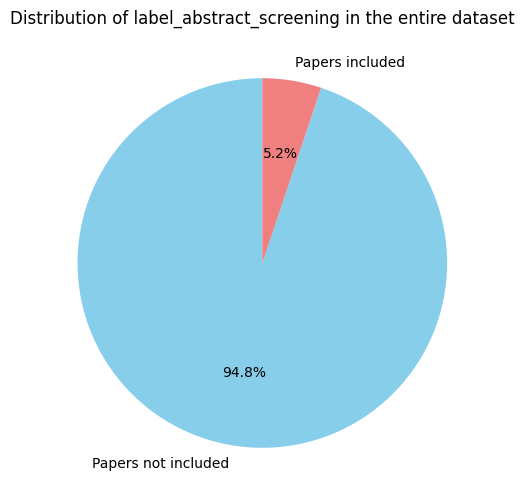

In [6]:
# Check the distribution of the target variable
def plot_target(df, column_name, set):

    plt.figure(figsize=(6, 6))
    values = df[column_name].value_counts()
    labels = values.index.map({0: 'Papers not included', 1: 'Papers included'})

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
    plt.title(f'Distribution of {column_name} in the {set}')
    plt.show()

plot_target(df, 'label_abstract_screening', 'entire dataset')

<br>
<br>

#### **1.3 Handle NaNs and irrelevant columns**

In [7]:
# Check the NaN situation
def count_nan(df):
    nan_counts = df.isnull().sum()
    return nan_counts

nan_counts = count_nan(df)
print("NaN counts per column:\n", nan_counts)

NaN counts per column:
 title                          1
abstract                    1094
keywords                      67
authors                        1
year                           0
date                        1130
doi                         1876
label_included                 0
label_abstract_screening       0
duplicate_record_id         3425
dtype: int64


In [8]:
# Remove the irrelevant columns
columns_to_remove = ['authors', 'year', 'date', 'doi', 'label_included', 'duplicate_record_id']
df = df.drop(columns=columns_to_remove)

In [9]:
# Handle NaNs for the most important columns
df['title'].fillna(value='Missing', inplace=True)
df['abstract'].fillna(value='Missing', inplace=True)
df['keywords'].fillna(value='Missing', inplace=True)

<br>
<br>

#### **1.4 Perform the train/validation/test split**

In [10]:
def shuffle_dataframe(df, random_seed):
    # Perform a random shuffle
    random.seed(random_seed)
    df_o = df.sample(frac=1, random_state=random_seed)
    return df_o

df1 = shuffle_dataframe(df, random_seed1d)
df2 = shuffle_dataframe(df, random_seed2d)
df3 = shuffle_dataframe(df, random_seed3d)
df4 = shuffle_dataframe(df, random_seed4d)
df5 = shuffle_dataframe(df, random_seed5d)

In [11]:
def split_dataframe(df):

    # Divide in train-validation-test (80-10-10)
    total_rows = len(df)
    train_end = int(0.8 * total_rows)
    val_end = int(0.9 * total_rows)

    # Perform the split
    train = df.iloc[:train_end]
    validation = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]

    return train, validation, test

# For the baseline definition we will use random seed 2d
df = shuffle_dataframe(df, random_seed2d)
train, validation, test = split_dataframe(df)

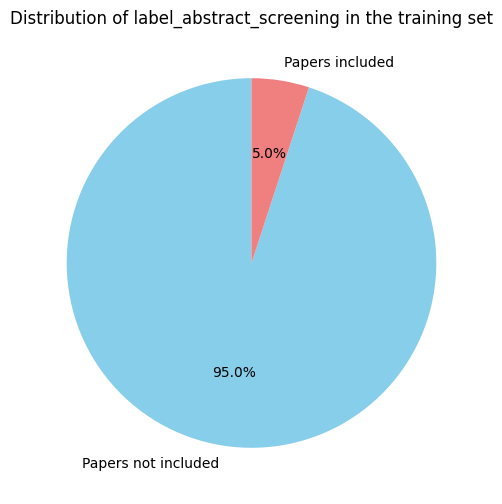

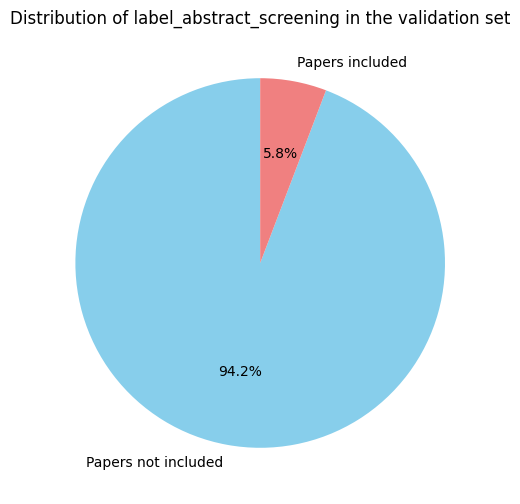

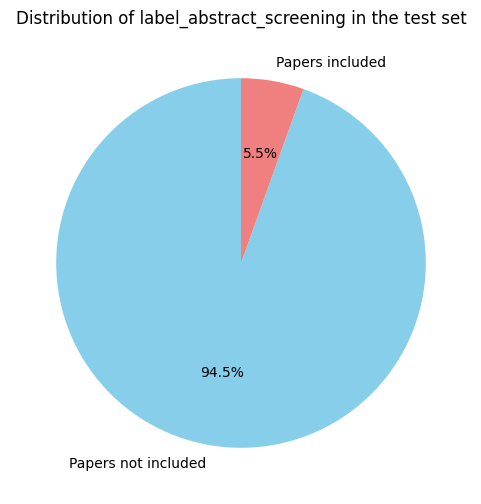

In [12]:
# Check that the distribution of the target variable is homogeneous
plot_target(train, 'label_abstract_screening', 'training set')
plot_target(validation, 'label_abstract_screening', 'validation set')
plot_target(test, 'label_abstract_screening', 'test set')

In [13]:
# Split obtaining 5 different training, validation and test set
train1, validation1, test1 = split_dataframe(df1)
train2, validation2, test2 = split_dataframe(df2)
train3, validation3, test3 = split_dataframe(df3)
train4, validation4, test4 = split_dataframe(df4)
train5, validation5, test5 = split_dataframe(df5)

print(f'The training set has {len(train1)} elements\nThe validation set has {len(validation1)} elements\nThe test set has {len(test1)} elements')

The training set has 2762 elements
The validation set has 345 elements
The test set has 346 elements


<br>
<br>

## **TASK 2 - BASELINES**

#### **2.1 Preprocessing of the dataset**

In [14]:
# Save changes on a different version of the dataset
train_baseline1 = train1; validation_baseline1 = validation1; test_baseline1 = test1
train_baseline2 = train2; validation_baseline2 = validation2; test_baseline2 = test2
train_baseline3 = train3; validation_baseline3 = validation3; test_baseline3 = test3
train_baseline4 = train4; validation_baseline4 = validation4; test_baseline4 = test4
train_baseline5 = train5; validation_baseline5 = validation5; test_baseline5 = test5

In [15]:
def concatenator(train_baseline, validation_baseline, test_baseline, train, validation, test):
    # Concatenate relevant text columns
    train_baseline['text_combined'] = train['title'] + ' ' + train['abstract'] + ' ' + train['keywords']
    validation_baseline['text_combined'] = validation['title'] + ' ' + validation['abstract'] + ' ' + validation['keywords']
    test_baseline['text_combined'] = test['title'] + ' ' + test['abstract'] + ' ' + test['keywords']
    return train_baseline, validation_baseline, test_baseline

train_baseline1, validation_baseline1, test_baseline1 = concatenator(train_baseline1, validation_baseline1, test_baseline1, train1, validation1, test1)
train_baseline2, validation_baseline2, test_baseline2 = concatenator(train_baseline2, validation_baseline2, test_baseline2, train2, validation2, test2)
train_baseline3, validation_baseline3, test_baseline3 = concatenator(train_baseline3, validation_baseline3, test_baseline3, train3, validation3, test3)
train_baseline4, validation_baseline4, test_baseline4 = concatenator(train_baseline4, validation_baseline4, test_baseline4, train4, validation4, test4)
train_baseline5, validation_baseline5, test_baseline5 = concatenator(train_baseline5, validation_baseline5, test_baseline5, train5, validation5, test5)

In [16]:
# Download NTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ricca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ricca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ricca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Preprocess the data
def preprocess_text(text):
    # Step 1: perform tokenization
    tokens = word_tokenize(text)

    # Step 2: lowercasing
    tokens = [word.lower() for word in tokens]

    # Step 3: remove stopwords and punctuation
    stop_words = set(stopwords.words('english') + list(string.punctuation))
    tokens = [word for word in tokens if word not in stop_words]

    # Step 4: lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

def apply_preprocessing(train_baseline, validation_baseline, test_baseline):
    # Apply text preprocessing to the 'text_combined' column
    train_baseline['preprocessed_text'] = train_baseline['text_combined'].apply(preprocess_text)
    validation_baseline['preprocessed_text'] = validation_baseline['text_combined'].apply(preprocess_text)
    test_baseline['preprocessed_text'] = test_baseline['text_combined'].apply(preprocess_text)
    return train_baseline, validation_baseline, test_baseline


train_baseline1, validation_baseline1, test_baseline1 = apply_preprocessing(train_baseline1, validation_baseline1, test_baseline1)
train_baseline2, validation_baseline2, test_baseline2 = apply_preprocessing(train_baseline2, validation_baseline2, test_baseline2)
train_baseline3, validation_baseline3, test_baseline3 = apply_preprocessing(train_baseline3, validation_baseline3, test_baseline3)
train_baseline4, validation_baseline4, test_baseline4 = apply_preprocessing(train_baseline4, validation_baseline4, test_baseline4)
train_baseline5, validation_baseline5, test_baseline5 = apply_preprocessing(train_baseline5, validation_baseline5, test_baseline5)


In [18]:
# Display the DataFrame with preprocessed text
print(train_baseline1[['preprocessed_text']])

                                           preprocessed_text
record_id                                                   
1332       case wilson 's disease psoriasis vulgaris comp...
1678       neuro-wilson disease seven case review literat...
502        generalised oedema lethargy personality distur...
2479       determination trace element organ tissue zinc ...
1559       wilson 's disease child rate liver cirrhosis i...
...                                                      ...
3068       therapeutic consideration wilson 's disease it...
3285       predictor seizure wilson disease clinico-radio...
2106       genetic disorder copper metabolism japanese ge...
141        potent long-lasting inhibition human p2x2 rece...
396        corneal encephalic abnormality missing adult b...

[2762 rows x 1 columns]


#### **2.2 Tokenization of the dataset**

In [19]:
# Tokenize the data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

def tokenizer(train_baseline, validation_baseline, test_baseline):
    X_train = vectorizer.fit_transform(train_baseline['preprocessed_text'])
    X_val = vectorizer.transform(validation_baseline['preprocessed_text'])
    X_test = vectorizer.transform(test_baseline['preprocessed_text'])
    return X_train, X_val, X_test

X_train1, X_val1, X_test1 = tokenizer(train_baseline1, validation_baseline1, test_baseline1)
X_train2, X_val2, X_test2 = tokenizer(train_baseline2, validation_baseline2, test_baseline2)
X_train3, X_val3, X_test3 = tokenizer(train_baseline3, validation_baseline3, test_baseline3)
X_train4, X_val4, X_test4 = tokenizer(train_baseline4, validation_baseline4, test_baseline4)
X_train5, X_val5, X_test5 = tokenizer(train_baseline5, validation_baseline5, test_baseline5)


In [20]:
# Save the datasets in lists
Xtrains = [X_train1, X_train2, X_train3, X_train4, X_train5]
Xvals = [X_val1, X_val2, X_val3, X_val4, X_val5]
Xtests = [X_test1, X_test2, X_test3, X_test4, X_test5]

# Save the baselines
trains = [train_baseline1, train_baseline2, train_baseline3, train_baseline4, train_baseline5]
vals = [validation_baseline1, validation_baseline2, validation_baseline3, validation_baseline4, validation_baseline5]
tests = [test_baseline1, test_baseline2, test_baseline3, test_baseline4, test_baseline5]

#### **2.3 Definition of the baselines**

In [21]:
# Define some models with a random seed
RFC = RandomForestClassifier(random_state=random_seed2d)
LR = LogisticRegression(random_state=random_seed2d)
SVM = SVC(random_state=random_seed2d)
NB = MultinomialNB()
XGB = XGBClassifier(random_state=random_seed2d)

#### **2.3 Evaluation of the baselines**

In [22]:
# Fit the models on all the datasets and obtain the predictions on the validation set
def fitter(model, Xtrains, trains, Xvals):
    predictions = []
    for i in range(len(Xtrains)):
        model.fit(Xtrains[i], trains[i]['label_abstract_screening'])
        validation_predictions = model.predict(Xvals[i])
        predictions.append(validation_predictions)
    return predictions


val_RFC_predictions = fitter(RFC, Xtrains, trains, Xvals)
val_LR_predictions = fitter(LR, Xtrains, trains, Xvals)
val_SVM_predictions = fitter(SVM, Xtrains, trains, Xvals)
val_NB_predictions = fitter(NB, Xtrains, trains, Xvals)
val_XGB_predictions = fitter(XGB, Xtrains, trains, Xvals)

In [23]:
def baseline_evaluation(validation_set, target_variable, predictions):
    accuracy = accuracy_score(validation_set[target_variable], predictions)
    precision = precision_score(validation_set[target_variable], predictions)
    recall = recall_score(validation_set[target_variable], predictions)
    macro_f1 = f1_score(validation_set[target_variable], predictions, average='macro')
    weighted_f1 = f1_score(validation_set[target_variable], predictions, average='weighted')
    return round(accuracy,3), round(precision,3), round(recall,3), round(macro_f1,3), round(weighted_f1,3)

metrics = ['Accuracy', 'Precision', 'Recall', 'MacroF1', 'WeightedF1']
models = ['RandomForestClassifier', 'LogisticRegression', 'SVM', 'NB', 'XGB']

def get_evaluation(vals, target_variable, predictions):
    results = []
    for i in range(5):
        result = baseline_evaluation(vals[i], target_variable, predictions[i])
        results.append(result)
    return results

RFC_results = get_evaluation(vals, 'label_abstract_screening', val_RFC_predictions)
LR_results = get_evaluation(vals, 'label_abstract_screening', val_LR_predictions)
SVM_results = get_evaluation(vals, 'label_abstract_screening', val_SVM_predictions)
NB_results = get_evaluation(vals, 'label_abstract_screening', val_NB_predictions)
XGB_results = get_evaluation(vals, 'label_abstract_screening', val_XGB_predictions)


In [24]:
# Compute an average
def average(results):
    result = []
    accuracy_sum = 0; precision_sum = 0; recall_sum = 0; macro_sum = 0; weighted_sum = 0
    for i in range(5):
        accuracy_sum += results[i][0]; precision_sum += results[i][1]; recall_sum += results[i][2]; macro_sum += results[i][3]; weighted_sum += results[i][4]

    accuracy_average = round(accuracy_sum/5, 3); precision_average = round(precision_sum/5, 3); recall_average = round(recall_sum/5, 3); macro_averge = round(macro_sum/5, 3); weighted_average = round(weighted_sum/5, 3)
    result.append(accuracy_average); result.append(precision_average); result.append(recall_average); result.append(macro_averge), result.append(weighted_average)
    return result

RFC_results = average(RFC_results)
LR_results = average(LR_results)
SVM_results = average(SVM_results)
NB_results = average(NB_results)
XGB_results = average(XGB_results)


In [25]:
# Display results
data = [RFC_results, LR_results, SVM_results, NB_results, XGB_results]

results = pd.DataFrame(data, columns=metrics, index=models)
results


,Accuracy,Precision,Recall,MacroF1,WeightedF1
RandomForestClassifier,0.944,0.733,0.093,0.567,0.922
LogisticRegression,0.947,0.843,0.166,0.624,0.930
SVM,0.952,0.960,0.201,0.647,0.936
NB,0.939,0.000,0.000,0.484,0.909
XGB,0.957,0.748,0.423,0.757,0.951


#### **2.4 Error analysis of the baselines (just on the last seed)**

In [26]:
# Get predictions on the test set
test_RFC_predictions = RFC.predict(X_test5)
test_LR_predictions = LR.predict(X_test5)
test_SVM_predictions = SVM.predict(X_test5)
test_NB_predictions = NB.predict(X_test5)
test_XGB_predictions = XGB.predict(X_test5)

In [27]:
conf_matrix_RFC = confusion_matrix(test_baseline5['label_abstract_screening'], test_RFC_predictions)
conf_matrix_LR = confusion_matrix(test_baseline5['label_abstract_screening'], test_LR_predictions)
conf_matrix_SVM = confusion_matrix(test_baseline5['label_abstract_screening'], test_SVM_predictions)
conf_matrix_NB = confusion_matrix(test_baseline5['label_abstract_screening'], test_NB_predictions)
conf_matrix_XGB = confusion_matrix(test_baseline5['label_abstract_screening'], test_XGB_predictions)

def plot_confusion_matrix(confusion_matrix, model, position):
    plt.subplot(2, 3, position)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={"size": 14}, linewidths=0.5, linecolor='black')

    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')


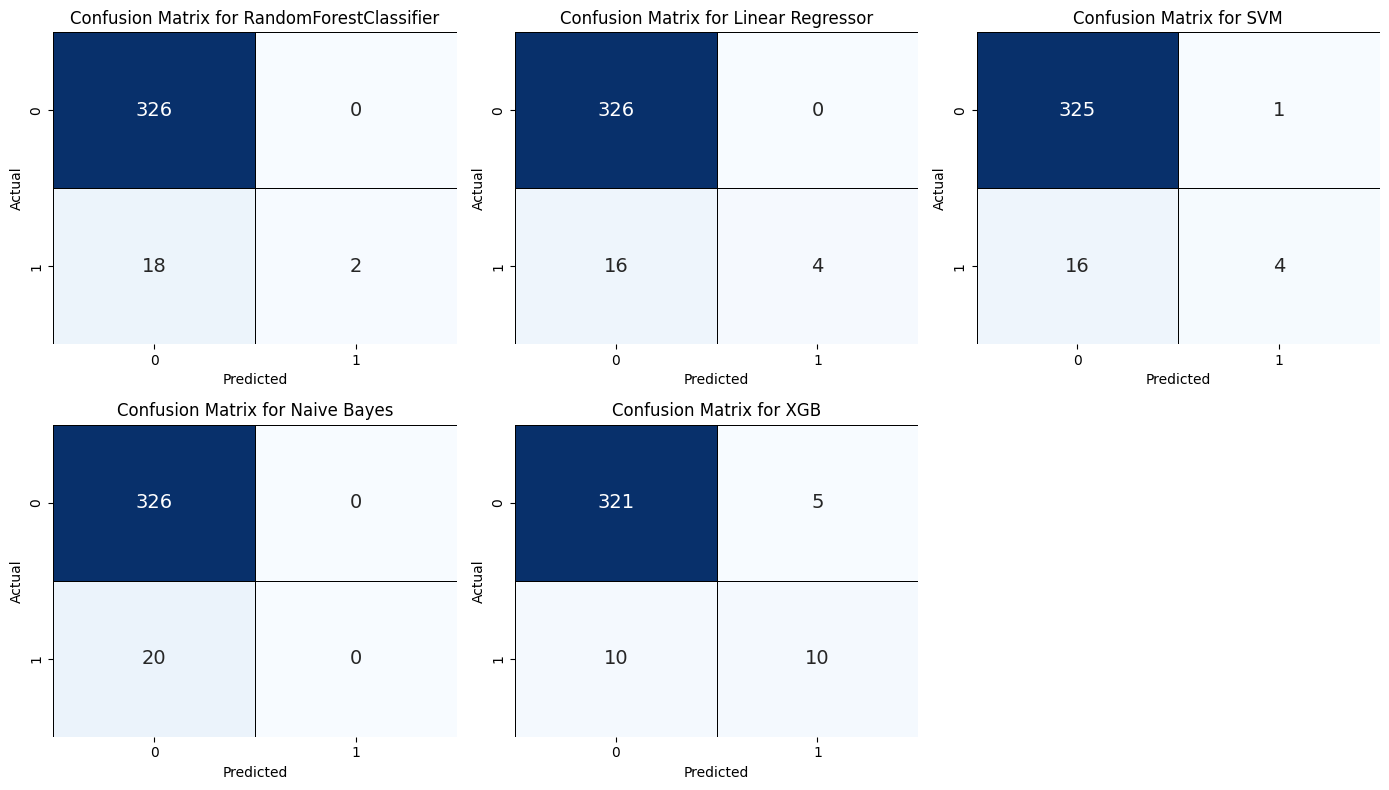

In [28]:
plt.figure(figsize=(14, 8))

plot_confusion_matrix(conf_matrix_RFC, 'RandomForestClassifier', 1)
plot_confusion_matrix(conf_matrix_LR, 'Linear Regressor', 2)
plot_confusion_matrix(conf_matrix_SVM, 'SVM', 3)
plot_confusion_matrix(conf_matrix_NB, 'Naive Bayes', 4)
plot_confusion_matrix(conf_matrix_XGB, 'XGB', 5)
plt.tight_layout()

<br>
<br>

## **TASK 3 - BERT MODEL**

#### **3.1 Dataset preparation**

In [29]:
# Add the "combined text column"
df1['text_combined'] = df1['title'] + ' ' + df1['abstract'] + ' ' + df1['keywords']
df2['text_combined'] = df2['title'] + ' ' + df2['abstract'] + ' ' + df2['keywords']
df3['text_combined'] = df3['title'] + ' ' + df3['abstract'] + ' ' + df3['keywords']
df4['text_combined'] = df4['title'] + ' ' + df4['abstract'] + ' ' + df4['keywords']
df5['text_combined'] = df5['title'] + ' ' + df5['abstract'] + ' ' + df5['keywords']

In [30]:
batch_size = 32
MAX_SEQUENCE_LENGTH = 2

In [31]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_text(text):
    return tokenizer(text, padding=True, truncation=True, max_length=MAX_SEQUENCE_LENGTH)

def tokenize_dataset(dataset, text_column):

    tokenized_texts = [preprocess_text(text) for text in dataset[text_column].tolist()]
    input_ids = [text['input_ids'] for text in tokenized_texts]
    attention_mask = [text['attention_mask'] for text in tokenized_texts]

    # Pad the lists to the maximum length
    input_ids = [lst + [0] * (MAX_SEQUENCE_LENGTH - len(lst)) for lst in input_ids]
    attention_mask = [lst + [0] * (MAX_SEQUENCE_LENGTH - len(lst)) for lst in attention_mask]

    # Array
    input_ids = np.array(input_ids, dtype=object)
    attention_mask = np.array(attention_mask, dtype=object)

    return input_ids, attention_mask

In [32]:
def dataloader_creator(batch_size, input_ids, attention_mask, dataset):
    tabon = []
    labels = dataset['label_abstract_screening']
    for i in range(0, len(labels) - batch_size + 1, batch_size):
        input_ids_batch = input_ids[i:i+batch_size].tolist()
        attention_mask_batch = attention_mask[i:i+batch_size].tolist()
        labels_batch = labels[i:i+batch_size].tolist()
        tabon.append([input_ids_batch, attention_mask_batch, labels_batch])

    return tabon

In [33]:
def Bert_input(train, validation, test):

    input_ids_train, attention_mask_train = tokenize_dataset(train, 'text_combined')
    input_ids_val, attention_mask_val = tokenize_dataset(validation, 'text_combined')
    input_ids_test, attention_mask_test = tokenize_dataset(test, 'text_combined')

    # Create dataloader objects
    train_dataloader = dataloader_creator(batch_size, input_ids_train, attention_mask_train, train)
    val_dataloader = dataloader_creator(batch_size, input_ids_val, attention_mask_val, validation)
    test_dataloader = dataloader_creator(batch_size, input_ids_test, attention_mask_test, test)

    return train_dataloader, val_dataloader, test_dataloader

In [34]:
train_dataloader1, val_dataloader1, test_dataloader1 = Bert_input(train1, validation1, test1)
train_dataloader2, val_dataloader2, test_dataloader2 = Bert_input(train2, validation2, test2)
train_dataloader3, val_dataloader3, test_dataloader3 = Bert_input(train3, validation3, test3)
train_dataloader4, val_dataloader4, test_dataloader4 = Bert_input(train4, validation4, test4)
train_dataloader5, val_dataloader5, test_dataloader5 = Bert_input(train5, validation5, test5)

In [35]:
train_dl_list = [train_dataloader1, train_dataloader2, train_dataloader3, train_dataloader4, train_dataloader5]
val_dl_list = [val_dataloader1, val_dataloader2, val_dataloader3, val_dataloader4, val_dataloader5]
test_dl_list = [test_dataloader1, test_dataloader2, test_dataloader3, test_dataloader4, test_dataloader5]

#### **3.2 Model definition**

In [36]:
def compute_class_weights(dataset_list):
    # Function to guide the training process by avoiding focusing too much on the most frequent emotion and trigger values
    article_labels = []

    for dataset in dataset_list:
      for batch in dataset:
        for el in batch[2]:
          article_labels.append(el)

    article_labels = [x for x in article_labels]

    unique_labels = torch.unique(torch.tensor(article_labels)).tolist()
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=article_labels)

    return class_weights

In [37]:
def model_evaluation(name, true_labels, predictions):
    labels = [x.cpu().numpy()  for y in true_labels for x in y]
    preds = [x.cpu().numpy()  for y in predictions for x in y]

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    weighted_f1 = f1_score(labels, preds, average='weighted')
    return round(accuracy,3), round(precision,3), round(recall,3), round(macro_f1,3), round(weighted_f1,3)

In [38]:
def training_loop(self, train_dataloader, val_dataloader, optimizer, criterion):
      training_loss = []
      validation_loss = []

      for epoch in range(self.num_epochs):
          counter = 0
          total_train_loss = 0.0
          self.train()

          for batch in train_dataloader:

               # obtain relevant information about the current batch
               input_ids = torch.tensor(batch[0]).to(device)
               attention_mask = torch.tensor(batch[1]).to(device)
               article_labels = torch.tensor(batch[2]).to(device)
               article_labels =  article_labels.to(dtype=torch.float32)

               # loss computation
               optimizer.zero_grad()
               article_logits = self(input_ids, attention_mask)

               loss = criterion(article_logits, article_labels)

               loss.backward()
               optimizer.step()
               total_train_loss += loss.item()
               counter += 1

               # print training behavior
               if counter % 20 == 0:
                  #print(f"Epoch {epoch+1}/{self.num_epochs}, Batch {counter}/{len(train_dataloader)}, Training Loss: {loss.item()}")
                  training_loss.append(loss.item())

               # print validation behavior
               if counter % 30 == 0:
                  self.eval()
                  val_loss = 0.0
                  with torch.no_grad():
                      for val_batch in val_dataloader:

                          # obtain relevant information about the current batch
                          input_ids_val = torch.tensor(val_batch[0]).to(device)
                          attention_mask_val = torch.tensor(val_batch[1]).to(device)
                          article_labels_val = torch.tensor(val_batch[2]).to(device)
                          article_labels_val =  article_labels_val.to(dtype=torch.float32)

                           # Logits
                          article_logits_val = self(input_ids_val, attention_mask_val)

                          loss = criterion(article_logits_val, article_labels_val)
                          val_loss += (loss).item()

                  average_val_loss = val_loss / len(val_dataloader)
                  validation_loss.append(average_val_loss)
                  print(f"Epoch {epoch+1}/{self.num_epochs}, Validation Loss: {average_val_loss}")
                  self.train()

          # average train loss of the current epoch
          average_loss = total_train_loss / len(train_dataloader)
          #print(f"Epoch {epoch+1}/{self.num_epochs}, Train Average Loss: {average_loss}")

      return training_loss, validation_loss

In [39]:
class MyBERT(nn.Module):
    def __init__(self, lr, num_epochs, model_card, seed=None):
        super(MyBERT, self).__init__()
        self.learning_rate = lr
        self.num_epochs = num_epochs

        self.seed = seed
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        # Architecture
        self.bert = BertModel.from_pretrained(model_card)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        logits = self.classifier(last_hidden_state[:, 0, :])
        logits = logits.squeeze(1)
        return logits

    def train_model(self, train_dataloader, val_dataloader):
        self.to(device)
        learning_rate = self.learning_rate
        optimizer = AdamW([
            {'params': self.bert.parameters(), 'lr': learning_rate},
            {'params': self.classifier.parameters(), 'lr': learning_rate}
        ])

        # Define a weighted loss
        class_weights = compute_class_weights([train_dataloader, val_dataloader])
        criterion_trigger = nn.BCEWithLogitsLoss(weight=torch.tensor(class_weights[1], dtype=torch.float32)).to(device)

        training_loss, validation_loss = training_loop(self, train_dataloader, val_dataloader, optimizer, criterion_trigger)
        return training_loss, validation_loss

    def predict(self, dataloader):
        self.eval()
        article_predictionsAll = []
        article_labelsAll = []

        with torch.no_grad():
            for batch in dataloader:

                # obtain relevant information about the current batch
                input_ids = torch.tensor(batch[0]).to(device)
                attention_mask = torch.tensor(batch[1]).to(device)
                article_labels = torch.tensor(batch[2]).to(device)

                article_logits = self(input_ids, attention_mask)
                article_probs = torch.sigmoid(article_logits)
                article_preds = (article_probs > 0.5).float()

                article_predictionsAll.append(article_preds)
                article_labelsAll.append(article_labels)

        return article_predictionsAll, article_labelsAll

    def evaluate(self, dataloader):
        article_predictionsAll, article_labelsAll = self.predict(dataloader)
        article_f1 = model_evaluation("Article", article_labelsAll, article_predictionsAll)
        return article_f1

In [40]:
model_card = 'bert-base-uncased'
num_epochs = 1
lr = 5e-5

#### **3.3 Model training and evaluation**

In [41]:
def mean_model(lr, num_epochs, model_card, random_seed):
    mean_result = [0,0,0,0,0]
    for i in range(len(train_dl_list)):

        model = MyBERT(lr, num_epochs, model_card, random_seed)
        print(f'Training on dataset {i}')
        train_loss_model, val_loss_model = model.train_model(train_dl_list[i], val_dl_list[i])
        print()
        res = model.evaluate(val_dl_list[i])
        for i in range(len(mean_result)):
          mean_result[i] += res[i]

    for i in range(len(mean_result)):
        mean_result[i] = round(mean_result[i]/len(train_dl_list), 3)
    return mean_result

In [42]:
print('Model 1 training\n')
mean1 = mean_model(lr, num_epochs, model_card, random_seed1d)
print('Model 2 training\n')
mean2 = mean_model(lr, num_epochs, model_card, random_seed2d)
print('Model 3 training\n')
mean3 = mean_model(lr, num_epochs, model_card, random_seed3d)
print('Model 4 training\n')
mean4 = mean_model(lr, num_epochs, model_card, random_seed4d)
print('Model 5 training\n')
mean5 = mean_model(lr, num_epochs, model_card, random_seed5d)

Model 1 training



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 0
Epoch 1/1, Validation Loss: 2.648759055137634
Epoch 1/1, Validation Loss: 2.7624984860420225



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 1
Epoch 1/1, Validation Loss: 2.43326475918293
Epoch 1/1, Validation Loss: 2.4702522829174995



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 2
Epoch 1/1, Validation Loss: 2.2885309219360352
Epoch 1/1, Validation Loss: 2.0904924869537354



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 3
Epoch 1/1, Validation Loss: 1.8283552944660186
Epoch 1/1, Validation Loss: 1.8471874177455903



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 4
Epoch 1/1, Validation Loss: 2.1320854663848876
Epoch 1/1, Validation Loss: 2.123249000310898

Model 2 training



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 0
Epoch 1/1, Validation Loss: 2.6595324754714964
Epoch 1/1, Validation Loss: 2.754266381263733



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 1
Epoch 1/1, Validation Loss: 2.4001855581998823
Epoch 1/1, Validation Loss: 2.4125609695911407



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 2
Epoch 1/1, Validation Loss: 2.16558997631073
Epoch 1/1, Validation Loss: 2.1474997997283936



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 3
Epoch 1/1, Validation Loss: 1.9104311421513558
Epoch 1/1, Validation Loss: 1.828413438796997



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 4
Epoch 1/1, Validation Loss: 2.1264100074768066
Epoch 1/1, Validation Loss: 2.1184923529624937

Model 3 training



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 0
Epoch 1/1, Validation Loss: 2.711768317222595
Epoch 1/1, Validation Loss: 2.8093196034431456



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 1
Epoch 1/1, Validation Loss: 2.5843004912137983
Epoch 1/1, Validation Loss: 2.745555119216442



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 2
Epoch 1/1, Validation Loss: 2.174721884727478
Epoch 1/1, Validation Loss: 2.0370840549468996



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 3
Epoch 1/1, Validation Loss: 1.8444347590208054
Epoch 1/1, Validation Loss: 1.9128370344638825



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 4
Epoch 1/1, Validation Loss: 2.196879988908768
Epoch 1/1, Validation Loss: 2.149208104610443

Model 4 training



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 0
Epoch 1/1, Validation Loss: 2.6559009671211244
Epoch 1/1, Validation Loss: 2.8172003030776978



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 1
Epoch 1/1, Validation Loss: 2.5340451925992964
Epoch 1/1, Validation Loss: 2.373906621336937



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 2
Epoch 1/1, Validation Loss: 2.1346407890319825
Epoch 1/1, Validation Loss: 2.032791781425476



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 3
Epoch 1/1, Validation Loss: 1.830379369854927
Epoch 1/1, Validation Loss: 1.8436132431030274



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 4
Epoch 1/1, Validation Loss: 2.1183499157428742
Epoch 1/1, Validation Loss: 2.154427942633629

Model 5 training



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 0
Epoch 1/1, Validation Loss: 2.6604399561882017
Epoch 1/1, Validation Loss: 2.9222344279289247



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 1
Epoch 1/1, Validation Loss: 2.3734819442033768
Epoch 1/1, Validation Loss: 2.75123166590929



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 2
Epoch 1/1, Validation Loss: 2.1894015789031984
Epoch 1/1, Validation Loss: 2.031894659996033



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 3
Epoch 1/1, Validation Loss: 1.8294968783855439
Epoch 1/1, Validation Loss: 1.8514714360237121



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on dataset 4
Epoch 1/1, Validation Loss: 2.1218975126743316
Epoch 1/1, Validation Loss: 2.119810140132904



In [43]:
results.loc['BERT model1'] = mean1
results.loc['BERT model2'] = mean2
results.loc['BERT model3'] = mean3
results.loc['BERT model4'] = mean4
results.loc['BERT model5'] = mean5

In [44]:
# Show and compare results
results

,Accuracy,Precision,Recall,MacroF1,WeightedF1
RandomForestClassifier,0.944,0.733,0.093,0.567,0.922
LogisticRegression,0.947,0.843,0.166,0.624,0.930
SVM,0.952,0.960,0.201,0.647,0.936
NB,0.939,0.000,0.000,0.484,0.909
XGB,0.957,0.748,0.423,0.757,0.951
BERT model1,0.941,0.000,0.000,0.485,0.912
BERT model2,0.941,0.000,0.000,0.485,0.912
BERT model3,0.941,0.000,0.000,0.485,0.912
BERT model4,0.941,0.000,0.000,0.485,0.912
BERT model5,0.941,0.000,0.000,0.485,0.912


#### **3.4 Error analysis of the model**

In [45]:
# The error analysis is performed on the best-performing BERT model (on average) on the 5th dataset
best_random_seed = random_seed3d
best_model = MyBERT(lr, num_epochs, model_card, best_random_seed)
train_loss_best_model, val_loss_best_model = best_model.train_model(train_dataloader5, val_dataloader5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/1, Validation Loss: 2.196879988908768
Epoch 1/1, Validation Loss: 2.149208104610443


In [46]:
def prediction_extractor(true_labels, predictions):
    labels = [x.cpu().numpy()  for y in true_labels for x in y]
    preds = [x.cpu().numpy()  for y in predictions for x in y]
    return labels, preds

def error_analysis(test_set, bert_model):
    predictions, true_labels = bert_model.predict(test_set)
    true_labels_extracted, predictions_extracted = prediction_extractor(true_labels, predictions)
    labels_list = [int(x) for x in true_labels_extracted]
    predictions_list = [int(x) for x in predictions_extracted]
    return predictions_list, labels_list

def plot_cf(true_labels_test, predictions_test):
    conf_matrix_BERT = confusion_matrix(true_labels_test, predictions_test)
    sns.heatmap(conf_matrix_BERT, annot=True, fmt='d', cmap='Blues', cbar=False,
                    annot_kws={"size": 14}, linewidths=0.5, linecolor='black')
    plt.title(f'Confusion Matrix for BERT model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual');

In [47]:
predictions_test, true_labels_test = error_analysis(test_dataloader5, best_model)

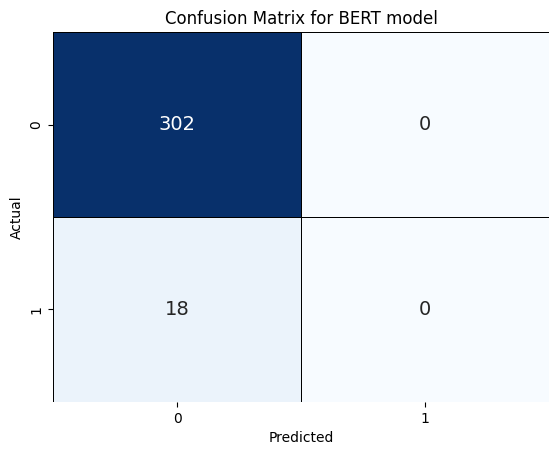

In [48]:
plot_cf(true_labels_test, predictions_test)


In [64]:
misclassified_indices = [idx for idx, (true, pred) in enumerate(zip(true_labels_test, predictions_test)) if true == 1 and pred == 0]
correct_indices = [idx for idx, (true, pred) in enumerate(zip(true_labels_test, predictions_test)) if true == 1 and pred == 1]

[]

In [70]:
abstract_values = test5.iloc[misclassified_indices]['abstract'].tolist()
abstract_correct_values = test5.iloc[correct_indices]['abstract'].tolist()

# Count occurrences of 'Missing' in abstract_values
missing_count = pd.Series(abstract_values).value_counts().get('Missing', 0)
missing_correct_count = pd.Series(abstract_correct_values).value_counts().get('Missing', 0)

print(f"Out of {len(misclassified_indices)} included papers that are not detected, {missing_count} were presented without abstract. It is the {round(missing_count/len(misclassified_indices) * 100, 1)}% of the total")
print(f"Out of {len(correct_indices)} included papers that are correctly detected, {len(correct_indices) - missing_correct_count} were presented without abstract. It is the {round(len(correct_indices) - missing_correct_count/(len(correct_indices)+1) * 100, 1)}% of the total")

Out of 18 included papers that are not detected, 2 were presented without abstract. It is the 11.1% of the total
Out of 0 included papers that are correctly detected, just 0 were presented without abstract. It is the 0.0% of the total


#### Error analysis conclusions